Searching for folder 'WR4' containing 'OCEAN_TEMPERATURE'...
--> FOUND IT: .\WR4-20251125T132718Z-1-001\WR4\OCEAN_TEMPERATURE
Loading Data...


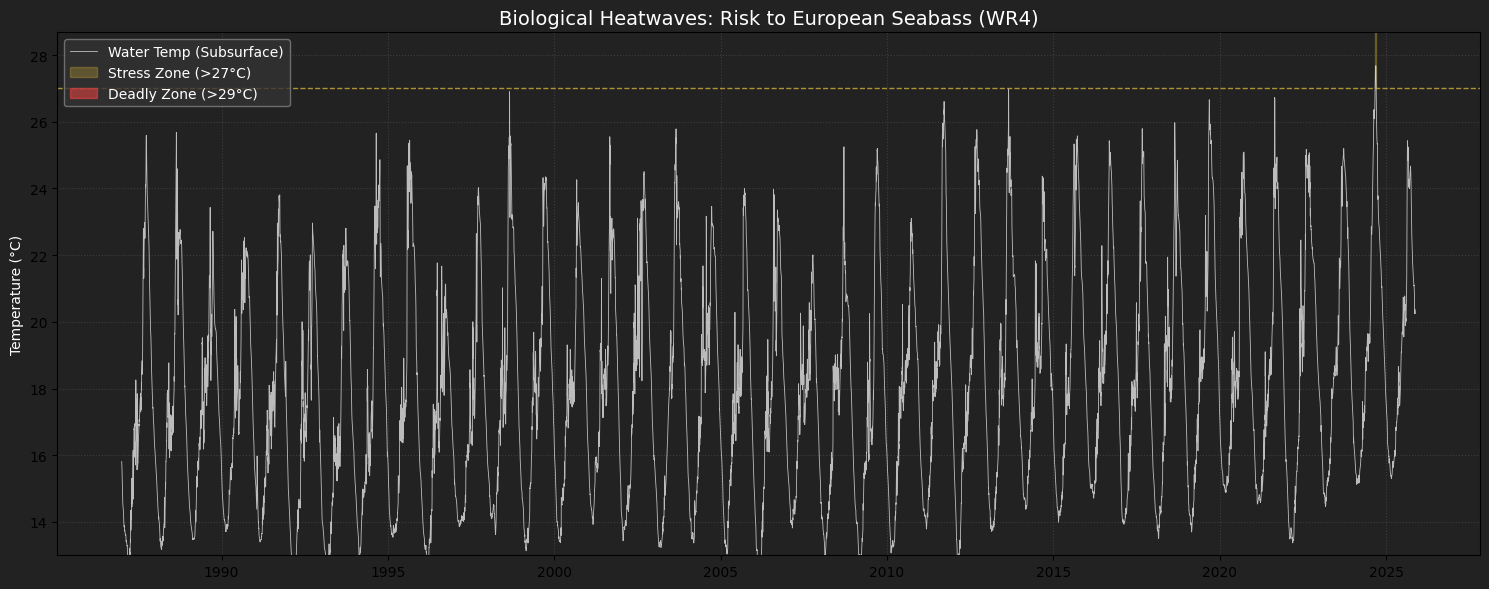


--- WR4 High Risk Events (Top 5) ---
start_date   end_date  duration_days  max_temp  avg_excess
2024-09-02 2024-09-14             13 27.682407    0.367132


In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np

# --- 1. SMART PATH FINDER ---
def find_data_path(target_folder="WR4", subfolder="OCEAN_TEMPERATURE"):
    """Searches for the WR4/OCEAN_TEMPERATURE path starting from current directory."""
    print(f"Searching for folder '{target_folder}' containing '{subfolder}'...")

    # Walk through the directory tree
    start_search = "." # Start from current project directory
    for root, dirs, files in os.walk(start_search):
        if target_folder in root and subfolder in dirs:
            found_path = os.path.join(root, subfolder)
            print(f"--> FOUND IT: {found_path}")
            return found_path

    print("Could not find the folder automatically. Please check your folders.")
    return None

# Execute search
path_to_files = find_data_path("WR4", "OCEAN_TEMPERATURE")

if path_to_files:
    # Construct the full pattern (*.nc)
    file_pattern = os.path.join(path_to_files, "*.nc")

    print("Loading Data...")
    try:
        # Load Data
        ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks={"time": -1})

        # Extract Subsurface Temp (Depth 5m)
        if 'depth' in ds.coords:
            # Select approx 5m depth (index 5 usually matches standard models, verify if needed)
            temp_series = ds['thetao'].isel(depth=5).load()
        else:
            temp_series = ds['thetao'].load()

        # --- 2. Define Biological Thresholds (Seabass) ---
        stress_temp = 27.0
        deadly_temp = 29.0

        # --- 3. Plotting ---
        fig, ax = plt.subplots(figsize=(15, 6))

        # Dark theme settings
        plt.style.use('dark_background')
        fig.patch.set_facecolor('#222222')
        ax.set_facecolor('#222222')

        # Plot Line
        ax.plot(temp_series.time, temp_series, color='white', linewidth=0.6, alpha=0.7, label='Water Temp (Subsurface)')

        # Plot Stress Zone
        ax.axhline(y=stress_temp, color='#d4af37', linestyle='--', linewidth=1, alpha=0.8)
        ax.fill_between(temp_series.time, stress_temp, deadly_temp,
                        where=(temp_series >= stress_temp),
                        color='#d4af37', alpha=0.3, label='Stress Zone (>27°C)')

        # Plot Deadly Zone
        max_val = float(temp_series.max()) + 1
        ax.axhline(y=deadly_temp, color='#ff4444', linestyle='--', linewidth=1, alpha=0.8)
        ax.fill_between(temp_series.time, deadly_temp, max_val,
                        where=(temp_series >= deadly_temp),
                        color='#ff4444', alpha=0.5, label='Deadly Zone (>29°C)')

        # Formatting
        ax.set_title("Biological Heatwaves: Risk to European Seabass (WR4)", fontsize=14, color='white')
        ax.set_ylabel("Temperature (°C)", color='white')
        ax.set_ylim(13, max_val)
        ax.grid(True, color='gray', linestyle=':', alpha=0.3)

        legend = ax.legend(loc='upper left', frameon=True, facecolor='#333333', edgecolor='gray')
        for text in legend.get_texts():
            text.set_color("white")

        plt.tight_layout()
        plt.show()

        # --- 4. Generate Event Table ---
        print("\n--- WR4 High Risk Events (Top 5) ---")
        df = temp_series.to_dataframe().reset_index()[['time', 'thetao']]
        hw_days = df[df['thetao'] > stress_temp].copy()

        if not hw_days.empty:
            hw_days['group'] = (hw_days['time'].diff().dt.days > 1).cumsum()
            events = []
            for _, group in hw_days.groupby('group'):
                start = group['time'].min()
                end = group['time'].max()
                events.append({
                    'start_date': start,
                    'end_date': end,
                    'duration_days': (end - start).days + 1,
                    'max_temp': group['thetao'].max(),
                    'avg_excess': (group['thetao'] - stress_temp).mean()
                })

            print(pd.DataFrame(events).sort_values(by='duration_days', ascending=False).head(5).to_string(index=False))
        else:
            print("Good news: No biological heatwaves detected above 27°C.")

    except Exception as e:
        print(f"An error occurred during processing: {e}")

else:
    print("ERROR: Could not find the WR4 folder automatically.")
    print("Please locate where you extracted the 'Data' zip file.")

Searching for 'OCEAN_TEMPERATURE' in 'WR4'...
Searching for 'MIXED_LAYER_DEPTH' in 'WR4'...
Folders found. Loading Data...
Processing monthly means...


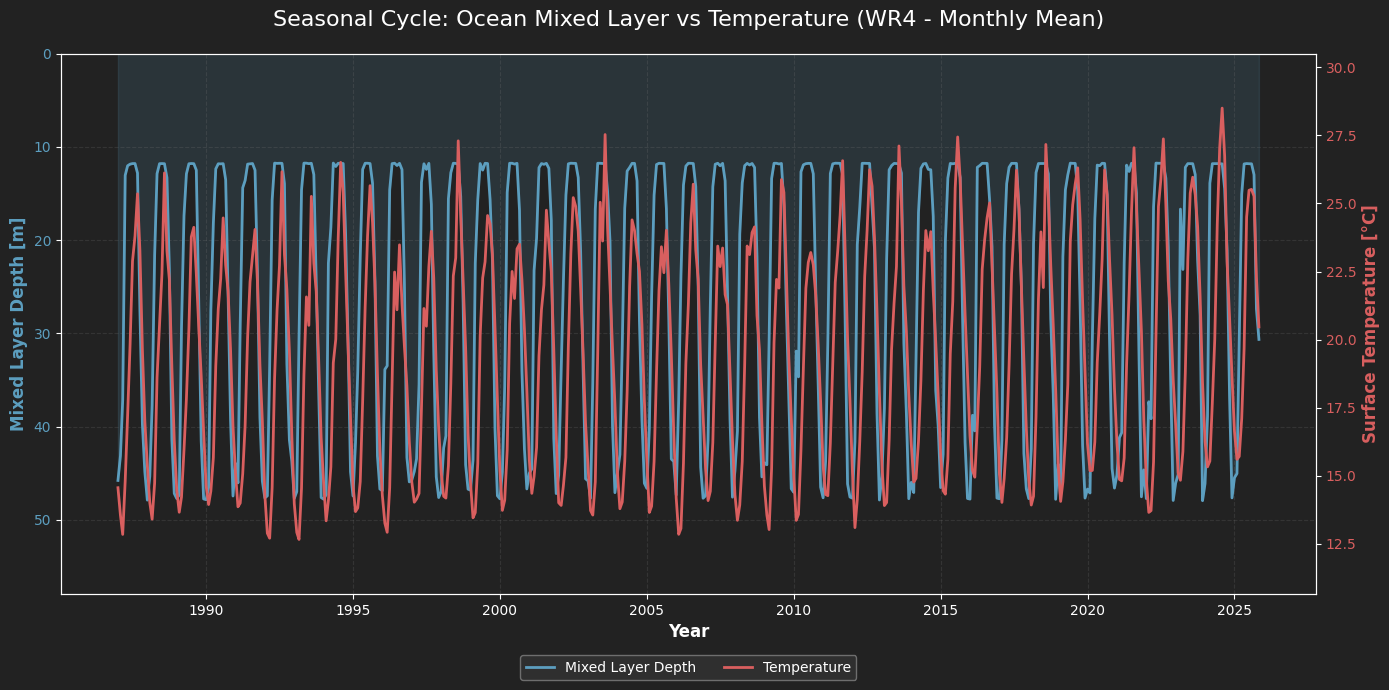

Correlation between Monthly MLD and Temperature in WR4: -0.62


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. SMART PATH FINDER ---
def find_data_path(target_folder="WR4", subfolder="OCEAN_TEMPERATURE"):
    """Searches for the specific subfolder inside the target region."""
    print(f"Searching for '{subfolder}' in '{target_folder}'...")
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in root and subfolder in dirs:
            return os.path.join(root, subfolder)
    return None

# Locate Folders for WR4
path_temp_dir = find_data_path("WR4", "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path("WR4", "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    print("Folders found. Loading Data...")

    # --- 2. Load & Merge Data ---
    # Construct file patterns (*.nc)
    path_temp = os.path.join(path_temp_dir, "*.nc")
    path_mld = os.path.join(path_mld_dir, "*.nc")

    # Load datasets (lazy loading with chunks)
    ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})
    ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})

    # Merge (inner join to align dates)
    ds_combined = xr.merge([ds_mld, ds_temp], join='inner')

    # --- 3. Data Processing (Monthly Means) ---
    print("Processing monthly means...")

    # Select variables (Surface Temp & MLD)
    # Handle depth dimension for temperature if it exists
    if 'depth' in ds_combined['thetao'].coords:
        surface_temp = ds_combined['thetao'].isel(depth=0)
    else:
        surface_temp = ds_combined['thetao']

    mld = ds_combined['mlotst']

    # Resample to Monthly Means ('1MS' = 1st of Month Start)
    # This smooths the daily noise and shows the clear seasonal cycle
    mld_monthly = mld.resample(time='1MS').mean().load()
    temp_monthly = surface_temp.resample(time='1MS').mean().load()

    # --- 4. Plotting ---
    # Set dark style
    plt.style.use('dark_background')

    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('#222222')
    ax1.set_facecolor('#222222')

    # --- Left Axis: MLD (Blue) ---
    color_mld = '#5c9ebf' # Muted Cyan/Blue
    ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
    ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')

    # Fill area for MLD
    ax1.fill_between(mld_monthly.time, mld_monthly, 0, color=color_mld, alpha=0.15)
    ax1.plot(mld_monthly.time, mld_monthly, color=color_mld, linewidth=2, label='Mixed Layer Depth')

    ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
    ax1.tick_params(axis='x', colors='white')

    # Invert Y-axis for depth (deeper = down)
    ax1.invert_yaxis()
    # Set logical limit (e.g., 0 to 120m depending on WR4 depth)
    max_mld = float(mld_monthly.max()) + 10
    ax1.set_ylim(max_mld, 0)

    # --- Right Axis: Temperature (Red) ---
    ax2 = ax1.twinx()
    color_temp = '#d95f5f' # Muted Red
    ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')

    ax2.plot(temp_monthly.time, temp_monthly, color=color_temp, linewidth=2, label='Temperature')

    ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

    # Set limits to avoid overlap (e.g. 10C to 35C)
    min_temp = float(temp_monthly.min()) - 2
    max_temp = float(temp_monthly.max()) + 2
    ax2.set_ylim(min_temp, max_temp)

    # --- Titles and Grid ---
    plt.title("Seasonal Cycle: Ocean Mixed Layer vs Temperature (WR4 - Monthly Mean)", fontsize=16, color='white', pad=20)

    # Custom grid
    ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

    # --- Legend ---
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()

    # Create a single combined legend at the bottom
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
               loc='upper center', bbox_to_anchor=(0.5, -0.1),
               ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

    plt.tight_layout()
    plt.show()

    # Optional: Correlation
    corr = xr.corr(mld_monthly, temp_monthly, dim='time')
    print(f"Correlation between Monthly MLD and Temperature in WR4: {corr.values:.2f}")

else:
    print("ERROR: Could not find WR4 data folders. Please check your directory structure.")

--- Processing WR4: MLD vs Ocean Temperature ---
Found Temp Dir: .\WR4-20251125T132718Z-1-001\WR4\OCEAN_TEMPERATURE
Found MLD Dir:  .\WR4-20251125T132718Z-1-001\WR4\MIXED_LAYER_DEPTH
Loading and sanitizing files...
Concatenating...
Processing variables...

RESULTS FOR WR4:
Correlation (r): -0.617
R-squared: 0.380
Generating Time Series Plot...


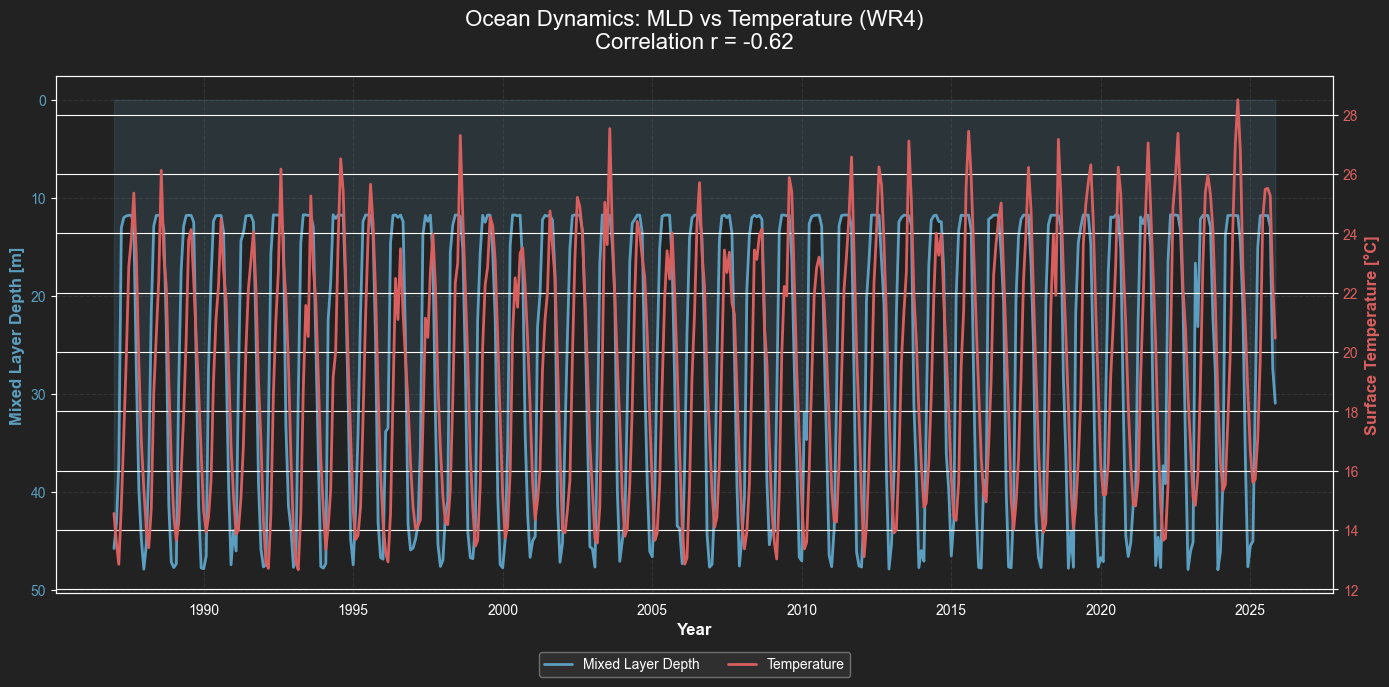

Generating Scatter Plot...


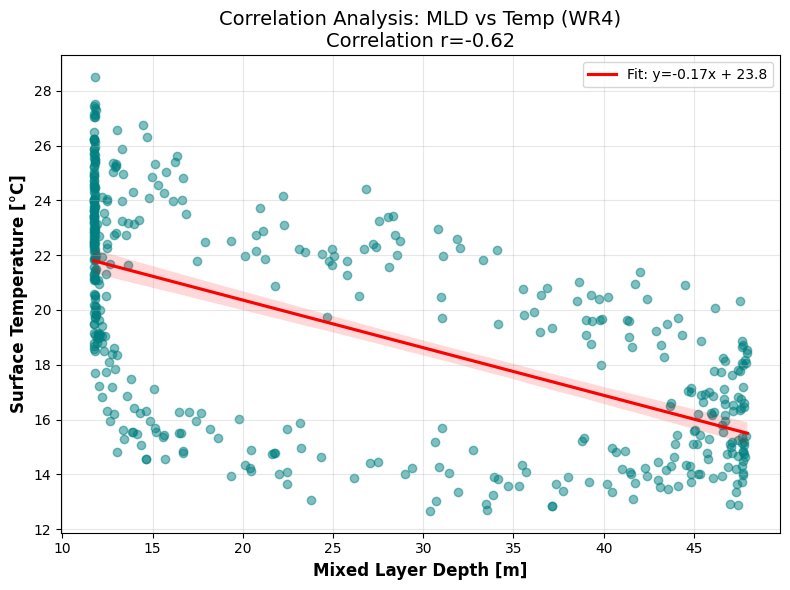

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import glob
import numpy as np
import sys

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "WR4"
print(f"--- Processing {region_name}: MLD vs Ocean Temperature ---")

# --- Helper 1: Find Folders Automatically ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
             possible_path = os.path.join(root, target_folder, subfolder)
             if os.path.exists(possible_path):
                 return possible_path
    return None

# --- Helper 2: Load & Sanitize (The "Bulletproof" Fix) ---
def load_and_sanitize(file_path):
    """
    Opens a NetCDF file, checks for corruption, and fixes coordinate errors.
    """
    try:
        # 1. Size Check
        if os.path.getsize(file_path) < 2000:
            print(f"Skipping small/corrupt file: {os.path.basename(file_path)}")
            return None

        # 2. Open Dataset (Try default, then h5netcdf, then scipy)
        try:
            ds = xr.open_dataset(file_path, chunks={"time": -1})
        except:
            try:
                ds = xr.open_dataset(file_path, chunks={"time": -1}, engine='h5netcdf')
            except:
                ds = xr.open_dataset(file_path, chunks={"time": -1}, engine='scipy')

        # 3. FIX: Round 'depth' to prevent non-monotonic errors
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)

        return ds
    except Exception as e:
        print(f"Error loading {os.path.basename(file_path)}: {e}")
        return None

# --- Main Execution ---

# 1. Locate Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    print(f"Found Temp Dir: {path_temp_dir}")
    print(f"Found MLD Dir:  {path_mld_dir}")

    files_temp = sorted(glob.glob(os.path.join(path_temp_dir, "*.nc")))
    files_mld = sorted(glob.glob(os.path.join(path_mld_dir, "*.nc")))

    if not files_temp or not files_mld:
        print("CRITICAL: Missing .nc files in one of the folders.")
    else:
        # 2. Robust Loading Loop
        print("Loading and sanitizing files...")
        ds_temp_list = [load_and_sanitize(f) for f in files_temp]
        ds_temp_list = [ds for ds in ds_temp_list if ds is not None]

        ds_mld_list = [load_and_sanitize(f) for f in files_mld]
        ds_mld_list = [ds for ds in ds_mld_list if ds is not None]

        # 3. Concatenate
        print("Concatenating...")
        try:
            ds_temp = xr.concat(ds_temp_list, dim='time', coords='minimal', compat='override')
            ds_mld = xr.concat(ds_mld_list, dim='time', coords='minimal', compat='override')
        except Exception as e:
            print(f"Concatenation failed: {e}")
            sys.exit()

        # 4. Process Variables
        print("Processing variables...")
        # Extract Surface Temp
        if 'depth' in ds_temp['thetao'].dims:
            surface_temp = ds_temp['thetao'].isel(depth=0)
        elif 'lev' in ds_temp['thetao'].dims:
            surface_temp = ds_temp['thetao'].isel(lev=0)
        else:
            surface_temp = ds_temp['thetao']

        # Spatial Means (if lat/lon dimensions exist)
        if 'lat' in surface_temp.dims: surface_temp = surface_temp.mean(dim=['lat', 'lon'])

        mld = ds_mld['mlotst']
        if 'lat' in mld.dims: mld = mld.mean(dim=['lat', 'lon'])

        # Resample to Monthly
        mld_monthly = mld.resample(time='1MS').mean().compute()
        temp_monthly = surface_temp.resample(time='1MS').mean().compute()

        # Merge
        ds_combined = xr.merge([mld_monthly.rename('MLD'), temp_monthly.rename('Temp')], join='inner')
        ds_combined = ds_combined.dropna(dim='time')

        # 5. Statistical Analysis
        x = ds_combined['MLD'].values
        y = ds_combined['Temp'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        print(f"\nRESULTS FOR {region_name}:")
        print(f"Correlation (r): {r_value:.3f}")
        print(f"R-squared: {r_value**2:.3f}")

        # --- PLOT 1: Time Series (Dark Mode) ---
        print("Generating Time Series Plot...")
        plt.style.use('dark_background')
        fig, ax1 = plt.subplots(figsize=(14, 7))
        fig.patch.set_facecolor('#222222')
        ax1.set_facecolor('#222222')

        # Left Axis: MLD
        color_mld = '#5c9ebf'
        ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
        ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
        ax1.fill_between(ds_combined.time, ds_combined['MLD'], 0, color=color_mld, alpha=0.15)
        ax1.plot(ds_combined.time, ds_combined['MLD'], color=color_mld, linewidth=2, label='Mixed Layer Depth')
        ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
        ax1.tick_params(axis='x', colors='white')
        ax1.invert_yaxis() # Deeper MLD goes down

        # Right Axis: Temp
        ax2 = ax1.twinx()
        color_temp = '#d95f5f'
        ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
        ax2.plot(ds_combined.time, ds_combined['Temp'], color=color_temp, linewidth=2, label='Temperature')
        ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

        plt.title(f"Ocean Dynamics: MLD vs Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
        ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

        plt.tight_layout()
        plt.show()

        # --- PLOT 2: Scatter Plot (Scientific) ---
        print("Generating Scatter Plot...")
        plt.style.use('default')
        plt.figure(figsize=(8, 6))

        sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'teal'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})

        plt.xlabel('Mixed Layer Depth [m]', fontsize=12, fontweight='bold')
        plt.ylabel('Surface Temperature [°C]', fontsize=12, fontweight='bold')
        plt.title(f"Correlation Analysis: MLD vs Temp ({region_name})\nCorrelation r={r_value:.2f}", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print(f"Error: Could not find data folders for {region_name}.")

--- Processing WR4: Ocean vs Atmospheric Temperature ---
Found Ocean Data: .\WR4-20251125T132718Z-1-001\WR4\OCEAN_TEMPERATURE
Found Atmos Data: .\WR4-20251125T132718Z-1-001\WR4\ATMOSPHERIC_DATA_WR4_1985_2023.csv
Loading Ocean Temperature files...
Concatenating ocean data...
Loading Atmospheric Data...
Using column '2m-air temperature' for Air Temperature.
Merging datasets...
Overlapping Data Points: 444

--- RESULTS ---
Correlation (r): 0.884
R-squared: 0.781


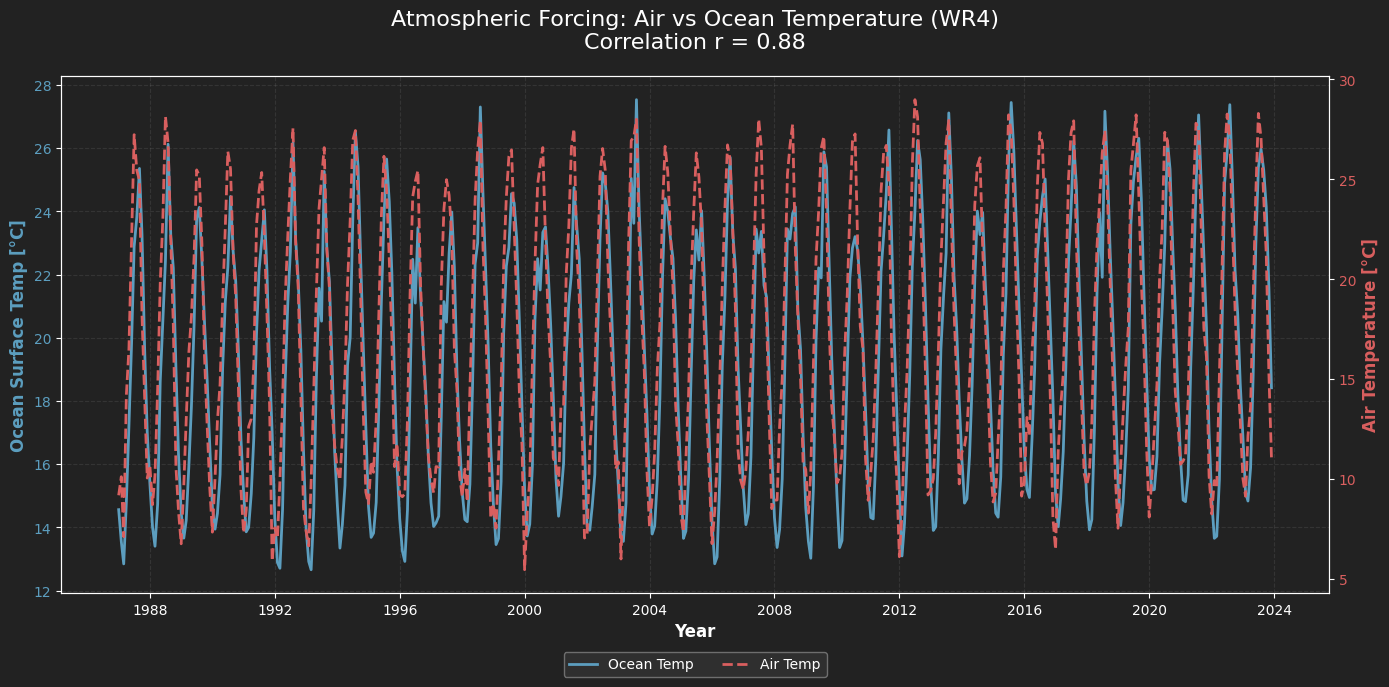

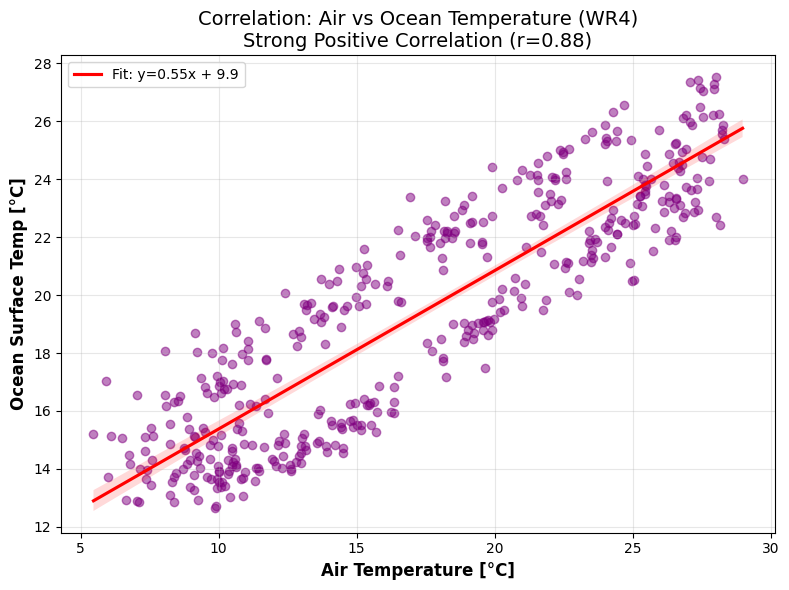

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import glob
import numpy as np
import sys

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "WR4"
atmos_filename_pattern = "ATMOSPHERIC_DATA_WR4"

print(f"--- Processing {region_name}: Ocean vs Atmospheric Temperature ---")

# --- Helper 1: Find Folders Automatically ---
def find_data_path(target_folder, subfolder_or_file):
    """
    Recursively searches for a folder or file pattern starting from the current directory.
    """
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        # Case 1: subfolder inside a region folder
        if target_folder in os.path.basename(root) and subfolder_or_file in dirs:
            return os.path.join(root, subfolder_or_file)

        # Case 2: File inside a region folder
        if target_folder in os.path.basename(root):
            for file in files:
                if subfolder_or_file in file:
                    return os.path.join(root, file)

        # Case 3: Direct check if path exists
        possible_path = os.path.join(root, target_folder, subfolder_or_file)
        if os.path.exists(possible_path):
            return possible_path

        # Case 4: File in current directory
        if os.path.isfile(subfolder_or_file) and subfolder_or_file in files:
             return os.path.join(root, subfolder_or_file)

    return None

# --- Helper 2: Load & Sanitize NetCDF ---
def load_and_sanitize(file_path):
    """
    Loads a NetCDF file and fixes common coordinate errors.
    """
    try:
        if os.path.getsize(file_path) < 2000:
            print(f"Skipping small/corrupt file: {os.path.basename(file_path)}")
            return None

        ds = xr.open_dataset(file_path, chunks={"time": -1})

        # FIX: Round the 'depth' coordinate to prevent 'non-monotonic index' errors
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)

        return ds
    except Exception as e:
        print(f"Warning: Could not load {os.path.basename(file_path)}: {e}")
        return None

# --- Main Execution ---

# 1. Locate Data
path_ocean_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_atmos_file = find_data_path(region_name, atmos_filename_pattern)

if path_ocean_dir and path_atmos_file:
    print(f"Found Ocean Data: {path_ocean_dir}")
    print(f"Found Atmos Data: {path_atmos_file}")

    # 2. Load Ocean Temperature
    print("Loading Ocean Temperature files...")
    files_temp = sorted(glob.glob(os.path.join(path_ocean_dir, "*.nc")))

    if not files_temp:
        print("CRITICAL: No .nc files found in the temperature folder.")
        sys.exit()

    temp_datasets = []
    for f in files_temp:
        ds = load_and_sanitize(f)
        if ds: temp_datasets.append(ds)

    if not temp_datasets:
        print("Error: No valid datasets loaded.")
        sys.exit()

    print("Concatenating ocean data...")
    try:
        ds_temp = xr.concat(temp_datasets, dim='time', coords='minimal', compat='override')

        # Select Surface Temperature (Depth=0)
        if 'depth' in ds_temp.dims:
            surface_temp = ds_temp['thetao'].isel(depth=0)
        elif 'lev' in ds_temp.dims:
            surface_temp = ds_temp['thetao'].isel(lev=0)
        else:
            surface_temp = ds_temp['thetao']

        # Spatial Mean
        if 'lat' in surface_temp.dims:
            surface_temp = surface_temp.mean(dim=['lat', 'lon'])

        # Resample to Monthly Mean
        ocean_monthly = surface_temp.resample(time='1MS').mean().compute()

    except Exception as e:
        print(f"Error processing ocean data: {e}")
        sys.exit()

    # 3. Load Atmospheric Data
    print("Loading Atmospheric Data...")
    df_atmos = pd.read_csv(path_atmos_file)

    # Clean column names
    df_atmos.columns = [c.strip() for c in df_atmos.columns]

    # Parse Dates
    try:
        df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M')
    except:
        df_atmos['time'] = pd.to_datetime(df_atmos['time'])

    # Find the Air Temperature column dynamically
    air_temp_col = [c for c in df_atmos.columns if 'temp' in c.lower() and 'air' in c.lower()]

    if not air_temp_col:
        print("Error: Could not find an 'Air Temperature' column in the CSV.")
        sys.exit()

    col_name = air_temp_col[0]
    print(f"Using column '{col_name}' for Air Temperature.")

    # Resample to Monthly Mean
    atmos_monthly = df_atmos.set_index('time')[[col_name]].resample('1MS').mean()

    # Convert to Xarray
    ds_atmos = xr.Dataset.from_dataframe(atmos_monthly)

    # 4. Merge and Correlate
    print("Merging datasets...")
    ds_combined = xr.merge([
        ocean_monthly.rename('Ocean_Temp'),
        ds_atmos.rename({col_name: 'Air_Temp'})
    ], join='inner')

    ds_combined = ds_combined.dropna(dim='time')
    print(f"Overlapping Data Points: {ds_combined.sizes['time']}")

    if ds_combined.sizes['time'] > 2:
        # Statistics
        x = ds_combined['Air_Temp'].values
        y = ds_combined['Ocean_Temp'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        print(f"\n--- RESULTS ---")
        print(f"Correlation (r): {r_value:.3f}")
        print(f"R-squared: {r_value**2:.3f}")

        # --- PLOT 1: Time Series (Dark Mode) ---
        plt.style.use('dark_background')
        fig, ax1 = plt.subplots(figsize=(14, 7))
        fig.patch.set_facecolor('#222222')
        ax1.set_facecolor('#222222')

        # Ocean Temp (Left Axis)
        color_ocean = '#5c9ebf' # Cyan/Blue
        ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
        ax1.set_ylabel('Ocean Surface Temp [°C]', color=color_ocean, fontsize=12, fontweight='bold')
        ax1.plot(ds_combined.time, ds_combined['Ocean_Temp'], color=color_ocean, linewidth=2, label='Ocean Temp')
        ax1.tick_params(axis='y', labelcolor=color_ocean, colors='white')
        ax1.tick_params(axis='x', colors='white')

        # Air Temp (Right Axis)
        ax2 = ax1.twinx()
        color_air = '#d95f5f' # Salmon/Red
        ax2.set_ylabel('Air Temperature [°C]', color=color_air, fontsize=12, fontweight='bold')
        ax2.plot(ds_combined.time, ds_combined['Air_Temp'], color=color_air, linewidth=2, linestyle='--', label='Air Temp')
        ax2.tick_params(axis='y', labelcolor=color_air, colors='white')

        plt.title(f"Atmospheric Forcing: Air vs Ocean Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
        ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                   loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

        plt.tight_layout()
        plt.show()

        # --- PLOT 2: Scatter Plot (Scientific Style) ---
        plt.style.use('default')
        plt.figure(figsize=(8, 6))
        sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'purple'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})

        plt.xlabel(f'Air Temperature [°C]', fontsize=12, fontweight='bold')
        plt.ylabel('Ocean Surface Temp [°C]', fontsize=12, fontweight='bold')
        plt.title(f"Correlation: Air vs Ocean Temperature ({region_name})\nStrong Positive Correlation (r={r_value:.2f})", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:
        print("Not enough overlapping data to create plots.")
else:
    print(f"Error: Could not find data folders or files for {region_name}.")